In [1]:
import numpy as np
import pandas as pd

import math
import gc
gc.collect()


0

### Load Data

In [2]:
seasons = list(range(2009,2019)) # creates list of years through 2018

# merge seasons into one df
df = pd.DataFrame()
for season in seasons:
    path = './../data/nflscrapR-data/play_by_play_data/regular_season/reg_pbp_'+str(season)+'.csv'
    season_df = pd.read_csv(path)
    season_df['season'] = season
    df = pd.concat([df, season_df], axis=0)
    
print(df.season.unique())

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (42,166,167,174,175,178,179,182,183,188,189,190,191,203,204,205,231,232,233,238,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (37,38,39,42,46,47,166,167,168,169,172,173,174,175,176,177,178,179,182,183,184,185,188,189,190,191,192,193,194,195,198,199,203,204,205,224,225,226,227,231,232,233,238,240,241,244,245,246,250) have mixed types. Speci

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


### Clean Steps

In [3]:
# standardize jaguars abbrev
df['posteam']=df['posteam'].replace('JAC','JAX')

# some typical cleaning that I don't do here

# drop redzone plays & inside own 5
# df = df.loc[(df.yardline_100 > 20) & (df.yardline_100 < 95)]

# drop extreme win probabilities (about 4% of plays)
# df = df.loc[(df['wp']>=0.05) | (df['wp']<=0.95)]

# drop afc and nfc

conf_teams = ['AFC','NFC','IRV','APR','NPR','RIC','SANS']
df = df.loc[~df['posteam'].isin(conf_teams)]
print(len(df))

452661


In [4]:
# eliminate special teams
pos_df = df.loc[(df['play_type']=='run') | (df['play_type']=='pass')]
print(len(pos_df))

321676


In [5]:
pos_df['first_down'] =  pos_df['first_down_rush'] + pos_df['first_down_pass']
print(len(pos_df))
pos_df = pos_df.loc[pos_df['first_down']<2]
print(len(pos_df))
pos_df = pos_df.dropna(subset=['first_down'])

321676


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


321675


In [6]:
# print(list(df))

pos_df = pos_df[['rusher_player_id','rusher_player_name','receiver_player_id','receiver_player_name','season','play_type','yards_gained','first_down', 'complete_pass', 'fumble','touchdown','safety','two_point_conv_result','epa','wpa']]

pos_df['two_point_conv_result'] = pos_df['two_point_conv_result'].apply(lambda x: 1 if x == 'success' else 0)

pos_df = pos_df.rename(columns={'complete_pass':'reception'})

# drop incompletions when calculating positional lpayers
pos_df = pos_df.loc[(pos_df['reception']==1) | (pos_df['play_type']=='run')]

pos_df = pos_df.drop(columns=['play_type'])

print(len(pos_df))
pos_df = pos_df.dropna(subset=[])
print(len(pos_df))

243456
243456


### Heatmap

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# change gc column order

fig, ax = plt.subplots(figsize=(16, 11))

# sns.heatmap(pos_df.corr(),
#             cmap='coolwarm',
#             annot=True,
#             fmt=".2f",
#             annot_kws={'size':10},
#             cbar=True,
#             square=False)

fig.savefig('./plots/Pos_Heatmap.png', bbox_inches='tight')
plt.show()

<Figure size 1600x1100 with 1 Axes>

In [8]:
pos_df.isna().sum()
pos_df = pos_df.dropna(subset=['yards_gained','epa','wpa'])

In [9]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression,Lasso 
from sklearn.metrics import log_loss




X_df = pos_df[['yards_gained','first_down', 'reception', 'fumble','touchdown','two_point_conv_result']]
X = X_df.values
y = pos_df['epa'].values
y2 = pos_df['wpa'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=17)

regressor = LinearRegression()
regressor.fit(X, y)

regressor2 = LinearRegression()
regressor2.fit(X, y2)

print("epa",regressor.score(X, y))
print("wpa",regressor2.score(X, y2))

multiplier = 0.1/regressor.coef_[0]
print("epa multiplier",multiplier)

multiplier2 = 0.1/regressor2.coef_[0]
print("wpa multiplier",multiplier2)

epa = regressor.coef_ * multiplier
wpa = regressor2.coef_ * multiplier2

wpa_rounded = [0.1,1,0.2,-3,2,2]

score_df = pd.DataFrame(zip(X_df.columns,epa, wpa, wpa_rounded), columns=['Stat','EPA fpts', 'WPA fpts', 'WPA rounded'])

score_df = score_df.reset_index()
score_df = score_df.drop(columns=['index'])
score_df = score_df.round(2)
score_df

epa 0.7342259214153263
wpa 0.4805374514458539
epa multiplier 1.4212393558018486
wpa multiplier 51.58027646297006


,Stat,EPA fpts,WPA fpts,WPA rounded
0,yards_gained,0.10,0.10,0.1
1,first_down,1.13,1.12,1.0
2,reception,0.18,0.15,0.2
3,fumble,-3.43,-2.90,-3.0
4,touchdown,1.70,1.72,2.0
5,two_point_conv_result,2.06,1.96,2.0


In [20]:
qb_df = df.loc[df['play_type']=='pass']

In [21]:
qb_df = qb_df[['season','passer_player_id','passer_player_name','yards_gained','first_down_pass', 'complete_pass','incomplete_pass','fumble','sack','interception','touchdown','two_point_conv_result','epa','wpa']]

qb_df['two_point_conv_result'] = qb_df['two_point_conv_result'].apply(lambda x: 1 if x == 'success' else 0)


def drop_receiver_fumbles(complete_pass,fumble):
    if complete_pass == 0:
        if fumble == 1:
            return 1
    return 0

# drop receiver fumbles (when there is a completed pass AND a fumble in the same play, fumble = 0)
print(qb_df['fumble'].sum())
qb_df['fumble'] = qb_df.apply(lambda row: drop_receiver_fumbles(row['complete_pass'],row['fumble']),axis=1)
print(qb_df['fumble'].sum())


3106.0
1828


In [22]:
print(qb_df.isna().sum())
qb_df = qb_df.dropna(subset=['yards_gained','epa','wpa'])

season                     0
passer_player_id           0
passer_player_name         0
yards_gained             104
first_down_pass            0
complete_pass              0
incomplete_pass            0
fumble                     0
sack                       0
interception               0
touchdown                  0
two_point_conv_result      0
epa                      547
wpa                      704
dtype: int64


In [23]:
print(len(qb_df))
qb_df = qb_df.dropna(subset=['epa'])
print(len(qb_df))

X_df = qb_df[['yards_gained','first_down_pass', 'complete_pass','fumble','sack','interception','touchdown','two_point_conv_result']]
X = X_df.values
y = qb_df['epa'].values
y2 = qb_df['wpa'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=17)

regressor = LinearRegression()
regressor.fit(X, y)

regressor2 = LinearRegression()
regressor2.fit(X, y2)

print("epa",regressor.score(X, y))
print("wpa",regressor2.score(X, y2))

multiplier = 0.1/regressor.coef_[0]
print("epa multiplier",multiplier)

multiplier2 = 0.1/regressor2.coef_[0]
print("wpa multiplier",multiplier2)

epa = regressor.coef_ * multiplier
wpa = regressor2.coef_ * multiplier2

wpa_rounded = [0.1,1.5,0.5,-2,-0.3,-4,2,3]

score_df = pd.DataFrame(zip(X_df.columns,epa, wpa, wpa_rounded), columns=['Stat','EPA fpts', 'WPA fpts', 'WPA rounded'])

score_df = score_df.reset_index()
score_df = score_df.drop(columns=['index'])
score_df = score_df.round(2)
score_df

186840
186840
epa 0.7706235323737743
wpa 0.5407277469735939
epa multiplier 1.5470164568183362
wpa multiplier 55.06756089003045


,Stat,EPA fpts,WPA fpts,WPA rounded
0,yards_gained,0.10,0.10,0.1
1,first_down_pass,1.53,1.48,1.5
2,complete_pass,0.60,0.58,0.5
3,fumble,-2.60,-1.78,-2.0
4,sack,-0.37,-0.27,-0.3
5,interception,-5.58,-4.15,-4.0
6,touchdown,1.43,1.77,2.0
7,two_point_conv_result,2.74,2.62,3.0


In [24]:
print(pos_df.rusher_player_id.head(7))

1            NaN
2     00-0022250
5     00-0026164
6            NaN
7     00-0026164
9            NaN
10           NaN
11    00-0022250
12           NaN
15    00-0026164
16           NaN
17    00-0026164
21    00-0026163
22    00-0026163
25           NaN
27           NaN
28    00-0024260
29           NaN
30           NaN
32    00-0022250
Name: rusher_player_id, dtype: object


In [42]:
pos_df['fpts'] = 0.1 * pos_df['yards_gained'] + pos_df['first_down'] + 0.2*pos_df['reception'] - 3 * pos_df['fumble'] + 2* pos_df['touchdown'] + 2*pos_df['two_point_conv_result']

pos_df['stand_fpts'] = 0.1 * pos_df['yards_gained'] + 0*pos_df['reception'] - 2 * pos_df['fumble'] + 6* pos_df['touchdown'] + 2*pos_df['two_point_conv_result']

pos_df['half_ppr_fpts'] = 0.1 * pos_df['yards_gained'] + 0.5*pos_df['reception'] - 2 * pos_df['fumble'] + 6* pos_df['touchdown'] + 2*pos_df['two_point_conv_result']

pos_df['ppr_fpts'] = 0.1 * pos_df['yards_gained'] + 1*pos_df['reception'] - 2 * pos_df['fumble'] + 6* pos_df['touchdown'] + 2*pos_df['two_point_conv_result']

compare = pos_df[['fpts','stand_fpts','half_ppr_fpts','ppr_fpts','epa','wpa']]


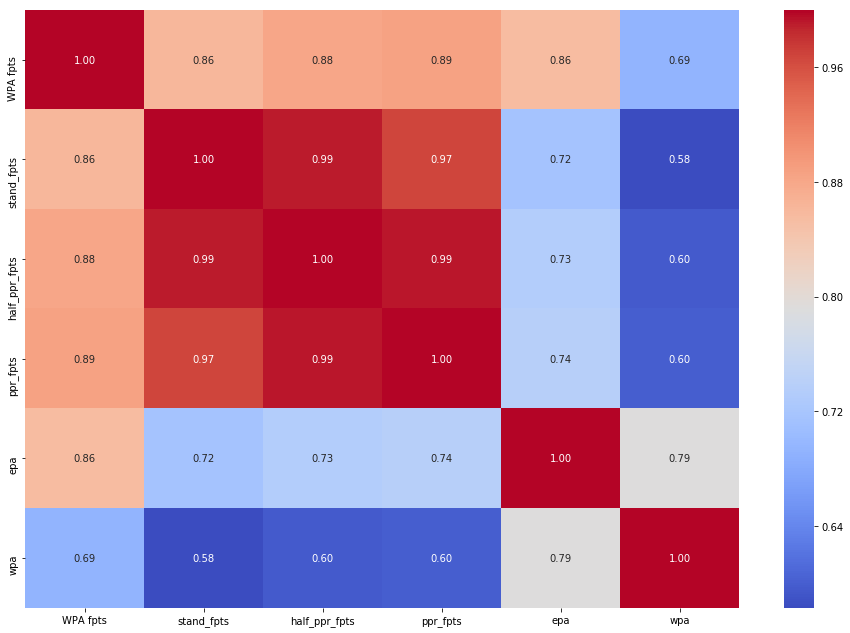

In [44]:
compare = compare.rename(columns={'fpts':'WPA fpts'})

fig, ax = plt.subplots(figsize=(16, 11))

sns.heatmap(compare.corr(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':10},
            cbar=True,
            square=False)

fig.savefig('./plots/Comp_Heatmap.png', bbox_inches='tight')
plt.show()

### 2018 Groupby Player

In [25]:
pos_df['fpts'] = 0.1 * pos_df['yards_gained'] + pos_df['first_down'] + 0.2*pos_df['reception'] - 3 * pos_df['fumble'] + 2* pos_df['touchdown'] + 2*pos_df['two_point_conv_result']

def get_id(rec, rush):
    if len(str(rec)) >4:
        return rec
    if len(str(rush)) >4:
        return rush
    return 

def get_name(rec, rush):
    if rec != math.nan:
        return rec
    if rush != math.nan:
        return rush
    return 


pos_df['pos_player_id'] = pos_df.apply(lambda row: get_id(row['receiver_player_id'],row['rusher_player_id']),axis=1)
pos_df['pos_player_name'] = pos_df.apply(lambda row: get_id(row['receiver_player_name'],row['rusher_player_name']),axis=1)



In [26]:
print(pos_df.season.unique())
gb18 = pos_df.loc[pos_df['season']==2018]
print(len(gb18))

gb = gb18.groupby(['pos_player_id','pos_player_name'])['fpts','wpa'].sum()
gb = gb.sort_values(by='fpts',ascending=False)
gb = gb.reset_index()

gb.to_csv('./output/positional.csv',index=False)
gb

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
24207


,pos_player_id,pos_player_name,fpts,wpa
0,00-0032241,T.Gurley,330.3,1.851274e+00
1,00-0033280,C.McCaffrey,322.8,1.949865e+00
2,00-0034844,S.Barkley,322.3,8.140210e-01
3,00-0033045,E.Elliott,310.5,1.492481e+00
4,00-0033906,A.Kamara,289.1,1.694341e+00
5,00-0027944,J.Jones,276.4,4.251102e+00
6,00-0030564,D.Hopkins,268.5,4.396962e+00
7,00-0033040,T.Hill,268.4,3.962904e+00
8,00-0032765,M.Thomas,248.8,3.578969e+00
9,00-0030035,A.Thielen,248.7,3.262507e+00


In [39]:
# get ids for rushing stats

qb_ids = qb_df.groupby(['passer_player_id'])['epa'].count().reset_index()
qb_ids = qb_ids.loc[qb_ids['epa'] > 100]
qb_ids = list(qb_ids['passer_player_id'].values)

qb_rushes = df.loc[df.play_type =='run']
qb_rushes = qb_rushes.loc[qb_rushes['season']==2018]
qb_rushes = qb_rushes.loc[qb_rushes.rusher_player_id.isin(qb_ids)]
print(len(qb_rushes))
# for easy merge & group
qb_rushes['passer_player_id'] = qb_rushes['rusher_player_id']
qb_rushes['passer_player_name'] = qb_rushes['rusher_player_name']
qb_rushes['two_point_conv_result'] = qb_rushes['two_point_conv_result'].apply(lambda x: 1 if x == 'success' else 0)

qb_rushes['fpts'] = 0.1 * qb_rushes['yards_gained'] + qb_rushes['first_down_rush'] + 0.2*qb_rushes['complete_pass'] - 3 * qb_rushes['fumble'] + 2* qb_rushes['touchdown'] + 2*qb_rushes['two_point_conv_result']





1435


	Stat	EPA fpts	WPA fpts	WPA rounded
0	yards_gained	0.10	0.10	0.1
1	first_down_pass	1.53	1.48	1.5
2	complete_pass	0.60	0.58	0.5
3	fumble	-2.60	-1.78	-2.0
4	sack	-0.37	-0.27	-0.3
5	interception	-5.58	-4.15	-4.0
6	touchdown	1.43	1.77	2.0
7	two_point_conv_result	2.74	2.62	3.0

In [40]:
qb_df['fpts'] = 0.1 * qb_df['yards_gained'] + 1.5 * qb_df['first_down_pass'] + 0.5 * qb_df['complete_pass'] - 2 *qb_df['fumble'] - 0.3*qb_df['sack'] - 4 * qb_df['interception'] + 2 * qb_df['touchdown'] + 3 * qb_df['two_point_conv_result']

print(qb_df.season.unique())
gb18 = qb_df.loc[qb_df['season']==2018]
print(len(gb18))

cols = list(gb18)
qb_rushes = qb_rushes[cols]
print(gb18.shape)
gb18 = pd.concat([gb18, qb_rushes])

print(gb18.shape)

gb = gb18.groupby(['passer_player_id','passer_player_name'])['fpts','wpa'].sum()
gb = gb.sort_values(by='fpts',ascending=False)
gb = gb.reset_index()

gb.to_csv('./output/qb.csv',index=False)
gb

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
18759
(18759, 15)
(20194, 15)


,passer_player_id,passer_player_name,fpts,wpa
0,00-0033873,P.Mahomes,1130.4,6.850784
1,00-0022924,B.Roethlisberger,1119.7,5.290724
2,00-0026143,M.Ryan,1068.1,4.861942
3,00-0029668,A.Luck,1040.9,3.419727
4,00-0033106,J.Goff,996.3,3.661263
5,00-0023459,A.Rodgers,959.4,2.489173
6,00-0029604,K.Cousins,949.7,1.223688
7,00-0022942,P.Rivers,922.4,3.976329
8,00-0033537,D.Watson,920.6,3.403244
9,00-0020531,D.Brees,915.5,5.306164
